In [1]:
import umap 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn
import torch 
import torch_geometric as pyg 
import sklearn 
from gsnn.models.GSNN import GSNN
import sys 
import argparse 
from torch.profiler import profile, record_function, ProfilerActivity
from gsnn_lib.data.LincsDataset import LincsDataset
import os 
from torch.utils.data import DataLoader
import scipy
from gsnn_lib.proc.prism.utils import load_prism
from sklearn.decomposition import PCA

# import pandas ols model 
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
targ2 = pd.read_csv('../../../data/targetome_extended-01-23-25.csv')
targ2.head()

,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,P78417,29652143.0,pubchem_bioassay,IC50,=,900000.0
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P0DMS8,19282184.0,pubchem_bioassay,Ki,>,100000.0
2,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29274,19282184.0,pubchem_bioassay,Ki,=,2200.0
3,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29275,19282184.0,pubchem_bioassay,Ki,>,30000.0
4,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P30542,19282184.0,pubchem_bioassay,Ki,=,7400.0


In [3]:
# average assay value within target and assay type 
targ_avg = targ2.groupby(['inchi_key', 'uniprot_id', 'assay_type'])[['assay_value']].mean().reset_index() #.agg(['mean', 'std', 'count', 'min', 'max']).reset_index()
targ_avg.head(25)

,inchi_key,uniprot_id,assay_type,assay_value
0,AAAAEENPAALFRN-UHFFFAOYSA-N,P56373,IC50,39.810
1,AAAAEENPAALFRN-UHFFFAOYSA-N,Q9UBL9,IC50,39.810
2,AAAAKTROWFNLEP-UHFFFAOYSA-N,P49137,IC50,20000.000
3,AAAAZQPHATYWOK-JXMROGBWSA-N,P00533,IC50,188.000
4,AAAAZQPHATYWOK-JXMROGBWSA-N,P04626,IC50,64.000
5,AAABTPAECTZDET-UHFFFAOYSA-N,P06239,IC50,137.000
6,AAACBXVBBDAYRQ-UHFFFAOYSA-N,Q5S007,IC50,15.850
7,AAADMRIIAVPPNA-UHFFFAOYSA-N,P08912,IC50,1380.190
8,AAADPBLPXCELKR-UHFFFAOYSA-N,P20309,IC50,3.981
9,AAADQEFQWNJHOZ-UHFFFAOYSA-N,P23975,IC50,5.000


In [4]:
targ_wide = targ_avg[['inchi_key', 'uniprot_id', 'assay_type', 'assay_value']].set_index(['inchi_key', 'uniprot_id']).pivot(columns='assay_type', values='assay_value')

In [5]:
targ_wide.head()

assay_type                              EC50      IC50  Kd  Ki
inchi_key                   uniprot_id                        
AAAAEENPAALFRN-UHFFFAOYSA-N P56373       NaN     39.81 NaN NaN
                            Q9UBL9       NaN     39.81 NaN NaN
AAAAKTROWFNLEP-UHFFFAOYSA-N P49137       NaN  20000.00 NaN NaN
AAAAZQPHATYWOK-JXMROGBWSA-N P00533       NaN    188.00 NaN NaN
                            P04626       NaN     64.00 NaN NaN

IC50 IC50 1.0
Ki IC50 0.7374039137255496
Ki Ki 1.0
Kd IC50 0.7071047970711435
Kd Ki 0.6803648865465486
Kd Kd 1.0
EC50 IC50 0.6127485792765341
EC50 Ki 0.5339233382486134
EC50 Kd 0.3822863083806775
EC50 EC50 1.0


/tmp/ipykernel_5081/1738868194.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


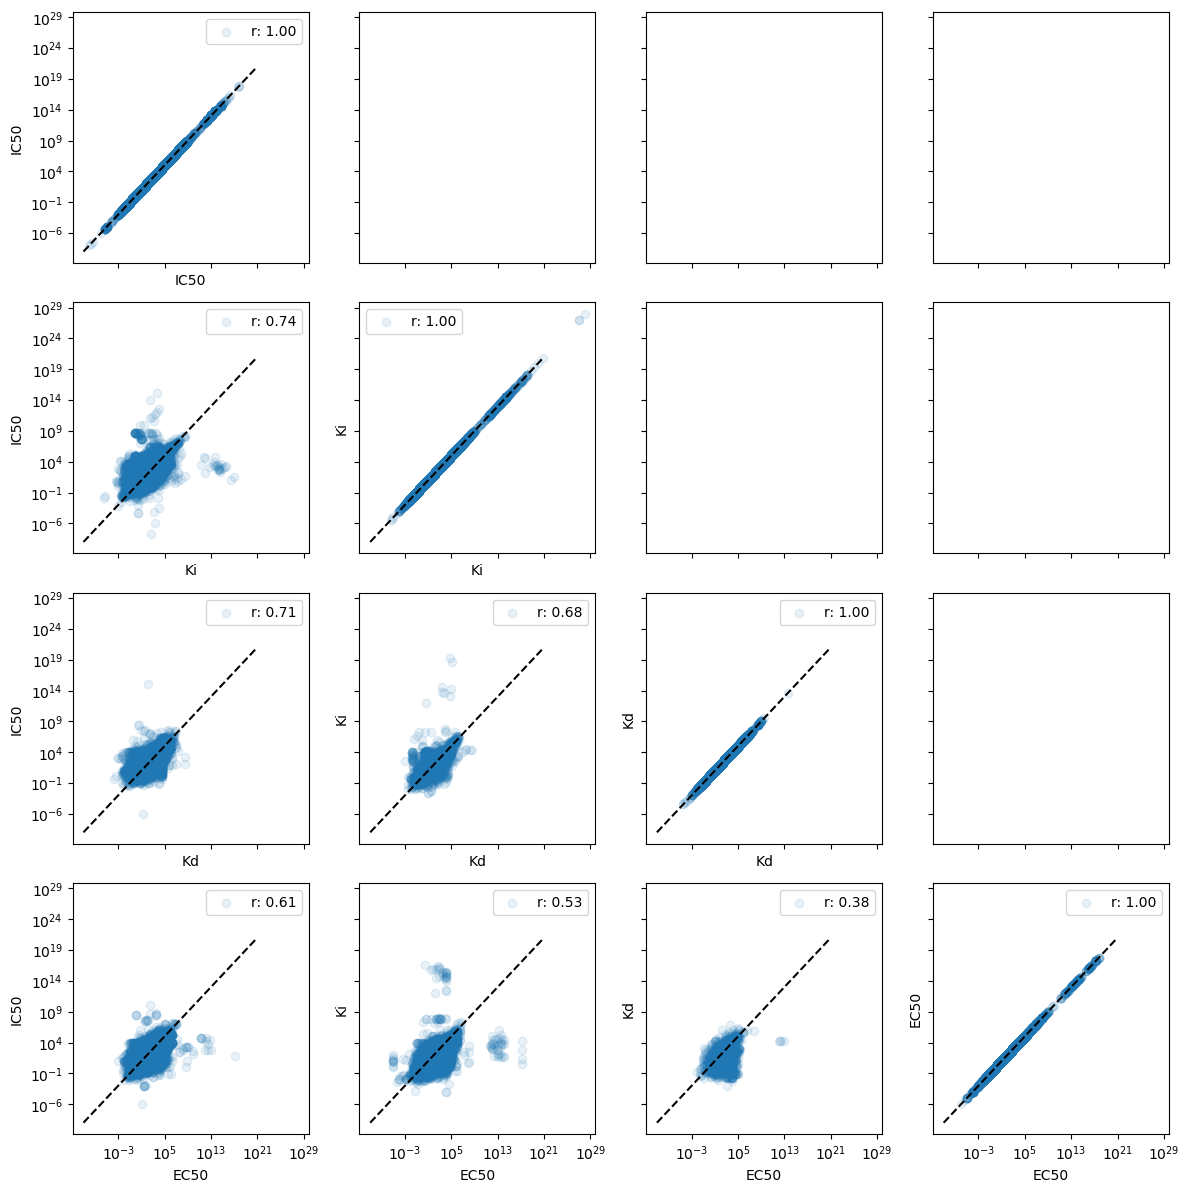

In [8]:
f, axes = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True)

# supress runtime warning 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

for i, atype1 in enumerate(['IC50', 'Ki', 'Kd', 'EC50']):
    for j, atype2 in enumerate(['IC50', 'Ki', 'Kd', 'EC50']):

        # don't plot the lower triangle 
        if i < j:
            continue

        print(i,j, end='\r')
        ax = axes[i,j]

        tmp = targ_wide[[atype1, atype2]]
        tmp = np.log10(tmp)
        r = tmp.dropna().corr(method='pearson').values[0,1]
        print(atype1, atype2, r)

        #r = np.corrcoef(tmp[atype1].values.ravel(), tmp[atype2].values.ravel())[0,1]
        ax.scatter(targ_wide[atype1], targ_wide[atype2], alpha=0.1 , label=f'r: {r:.2f}')

        # set a diagonal line 
        ax.plot([1e-9, 1e21], [1e-9, 1e21], color='black', linestyle='--')

        ax.set_xlabel(atype1)
        ax.set_ylabel(atype2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

plt.tight_layout()
plt.show() 

In [17]:
_targ_wide.reset_index().head()

database,inchi_key,uniprot_id,bindingdb,iuphar,pubchem_bioassay,sorger_sms
0,AAAAEENPAALFRN-UHFFFAOYSA-N,P56373,NaN,NaN,39.81,NaN
1,AAAAEENPAALFRN-UHFFFAOYSA-N,Q9UBL9,NaN,NaN,39.81,NaN
2,AAAAKTROWFNLEP-UHFFFAOYSA-N,P49137,NaN,NaN,20000.00,NaN
3,AAAAZQPHATYWOK-JXMROGBWSA-N,P00533,NaN,NaN,188.00,NaN
4,AAAAZQPHATYWOK-JXMROGBWSA-N,P04626,NaN,NaN,64.00,NaN


bindingdb bindingdb 1.0
iuphar bindingdb 0.7747929752372593
iuphar iuphar 1.0
pubchem_bioassay bindingdb 0.9073651078815379
pubchem_bioassay iuphar 0.6913807160616763
pubchem_bioassay pubchem_bioassay 1.0
sorger_sms bindingdb 0.9178766120368111
sorger_sms iuphar 0.7985497097736793
sorger_sms pubchem_bioassay 0.8969157778927551
sorger_sms sorger_sms 1.0


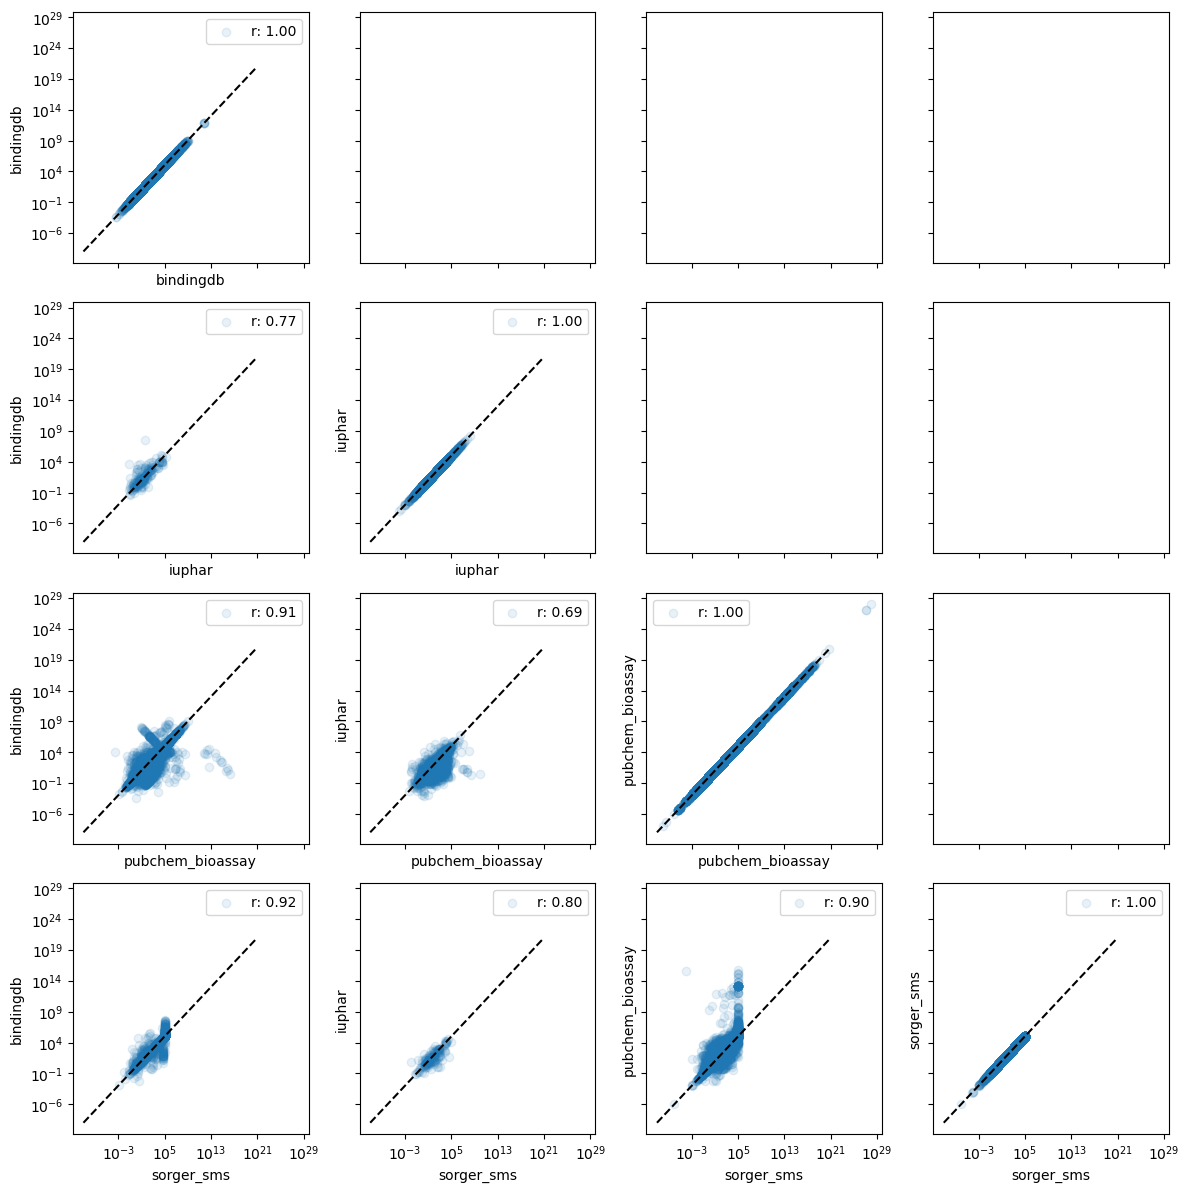

In [19]:
# how do assay values between databases compare
_targ_avg = targ2.groupby(['inchi_key', 'uniprot_id', 'database'])[['assay_value']].mean().reset_index() #.agg(['mean', 'std', 'count', 'min', 'max']).reset_index()
_targ_wide = _targ_avg[['inchi_key', 'uniprot_id', 'database', 'assay_value']].set_index(['inchi_key', 'uniprot_id']).pivot(columns='database', values='assay_value').reset_index()

f, axes = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True)

# supress runtime warning 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

for i, atype1 in enumerate(['bindingdb', 'iuphar', 'pubchem_bioassay', 'sorger_sms']):
    for j, atype2 in enumerate(['bindingdb', 'iuphar', 'pubchem_bioassay', 'sorger_sms']):

        # don't plot the lower triangle 
        if i < j:
            continue

        print(i,j, end='\r')
        ax = axes[i,j]

        tmp = _targ_wide[[atype1, atype2]]
        tmp = np.log10(tmp)
        r = tmp.dropna().corr(method='pearson').values[0,1]
        print(atype1, atype2, r)

        #r = np.corrcoef(tmp[atype1].values.ravel(), tmp[atype2].values.ravel())[0,1]
        ax.scatter(_targ_wide[atype1], _targ_wide[atype2], alpha=0.1 , label=f'r: {r:.2f}')

        # set a diagonal line 
        ax.plot([1e-9, 1e21], [1e-9, 1e21], color='black', linestyle='--')

        ax.set_xlabel(atype1)
        ax.set_ylabel(atype2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

plt.tight_layout()
plt.show() 

In [22]:
# 

regdf = targ2.assign(target_key = targ2.inchi_key + '_' + targ2.uniprot_id)[['pubchem_cid', 'target_key', 'assay_type', 'assay_value']].drop_duplicates()

# subsample targets 
targets = np.random.choice(regdf.target_key.unique(), 2500, replace=False)
regdf = regdf[regdf.target_key.isin(targets)]

# cast pubchem_cid to string
regdf.pubchem_cid = regdf.pubchem_cid.astype(str)
# log transform assay value 
regdf.assay_value = np.log10(regdf.assay_value + 1e-20)

# run regression to predict assay value 
model = ols('assay_value ~ target_key + assay_type', data=regdf).fit()

model.summary2().tables[1][lambda x: x.index.str.contains('assay_type')]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
assay_type[T.IC50],0.135624,0.138533,0.979001,0.328263,-0.136849,0.408098
assay_type[T.Kd],0.199885,0.259367,0.770664,0.441432,-0.310249,0.710018
assay_type[T.Ki],-0.254234,0.145198,-1.750946,0.080841,-0.539816,0.031348


In [23]:
regdf = targ2.assign(target_key = targ2.inchi_key + '_' + targ2.uniprot_id)[['pubchem_cid', 'target_key', 'assay_type', 'assay_value']].drop_duplicates()

# subsample targets 
targets = np.random.choice(regdf.target_key.unique(), 2500, replace=False)
regdf = regdf[regdf.target_key.isin(targets)]

# cast pubchem_cid to string
regdf.pubchem_cid = regdf.pubchem_cid.astype(str)
# log transform assay value 
regdf.assay_value = np.log10(regdf.assay_value + 1e-20)

# run regression to predict assay value 
model = ols('assay_value ~ target_key + assay_type', data=regdf).fit()

model.summary2().tables[1][lambda x: x.index.str.contains('assay_type')]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
assay_type[T.IC50],-0.393099,0.138312,-2.842119,0.004756,-0.665168,-0.121030
assay_type[T.Kd],-0.926232,0.303334,-3.053508,0.002443,-1.522910,-0.329553
assay_type[T.Ki],-0.647806,0.159148,-4.070468,0.000059,-0.960860,-0.334751


In [24]:
regdf = targ2.assign(target_key = targ2.inchi_key + '_' + targ2.uniprot_id)[['pubchem_cid', 'target_key', 'assay_type', 'assay_value']].drop_duplicates()

# subsample targets 
targets = np.random.choice(regdf.target_key.unique(), 2500, replace=False)
regdf = regdf[regdf.target_key.isin(targets)]

# cast pubchem_cid to string
regdf.pubchem_cid = regdf.pubchem_cid.astype(str)
# log transform assay value 
regdf.assay_value = np.log10(regdf.assay_value + 1e-20)

# run regression to predict assay value 
model = ols('assay_value ~ target_key + assay_type', data=regdf).fit()

model.summary2().tables[1][lambda x: x.index.str.contains('assay_type')]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
assay_type[T.IC50],-0.483447,0.131824,-3.667360,2.703922e-04,-0.742422,-0.224471
assay_type[T.Kd],-0.912144,0.310066,-2.941772,3.409487e-03,-1.521285,-0.303002
assay_type[T.Ki],-1.020762,0.153556,-6.647483,7.575856e-11,-1.322432,-0.719093


In [30]:
targ2.head()

,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,P78417,29652143.0,pubchem_bioassay,IC50,=,900000.0
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P0DMS8,19282184.0,pubchem_bioassay,Ki,>,100000.0
2,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29274,19282184.0,pubchem_bioassay,Ki,=,2200.0
3,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29275,19282184.0,pubchem_bioassay,Ki,>,30000.0
4,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P30542,19282184.0,pubchem_bioassay,Ki,=,7400.0


In [40]:
targ2.groupby('assay_relation').count()[['assay_value']]

,assay_value
assay_relation,
<,10961
<<,2
<=,1060
=,1141324
>,332823
>=,1683
>>,75
~,253


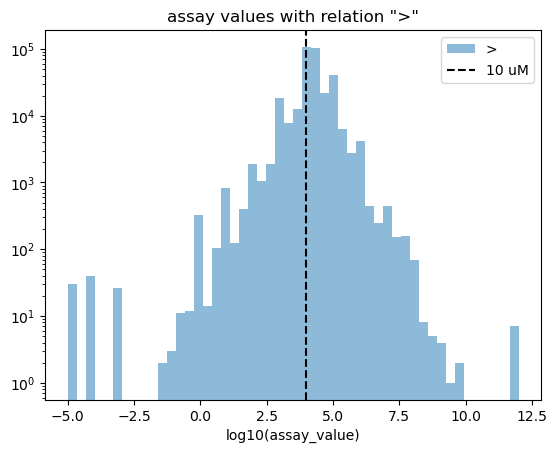

In [69]:
plt.figure()
plt.title('assay values with relation ">"')
plt.hist(np.log10( targ2[lambda x: x.assay_relation == '>'].assay_value), bins=50, alpha=0.5, label='>')
plt.axvline(np.log10(10 * 1e3), color='black', linestyle='--', label='10 uM')
plt.xlabel('log10(assay_value)')
plt.yscale('log')
plt.legend()
plt.show() 

In [41]:
targ2[lambda x: x.assay_relation == '>'].assay_value.min()

1e-05

In [48]:
targ3 = targ2.assign(lt_10uM = targ2.assay_value < 10 * 1e3)
targ3 = targ3.groupby(['inchi_key', 'uniprot_id'])[['assay_value', 'lt_10uM']].agg(['mean', 'count', 'std'])#.reset_index()
targ3.head()


assay_value           lt_10uM          
                                              mean count std    mean count std
inchi_key                   uniprot_id                                        
AAAAEENPAALFRN-UHFFFAOYSA-N P56373           39.81     1 NaN     1.0     1 NaN
                            Q9UBL9           39.81     1 NaN     1.0     1 NaN
AAAAKTROWFNLEP-UHFFFAOYSA-N P49137        20000.00     1 NaN     0.0     1 NaN
AAAAZQPHATYWOK-JXMROGBWSA-N P00533          188.00     1 NaN     1.0     1 NaN
                            P04626           64.00     1 NaN     1.0     1 NaN

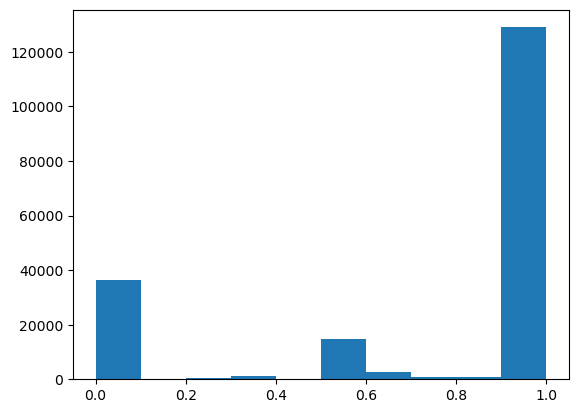

In [ ]:


plt.figure()
plt.hist(targ3[targ3[('assay_value', 'count')] > 1][('lt_10uM', 'mean')], bins=10)
plt.show()

# of targets with at least 2 assays: 186351/1242670


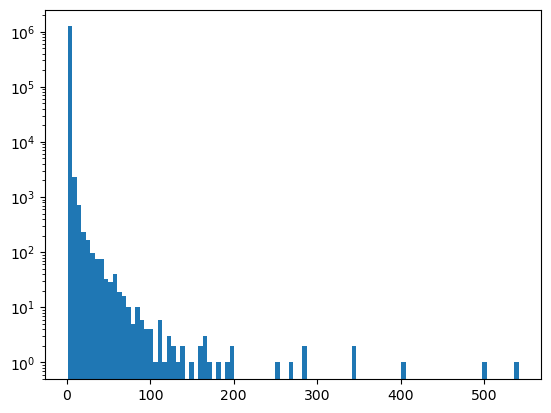

In [55]:
print(f'# of targets with at least 2 assays: {(targ3[('assay_value', 'count')] > 1).sum()}/{len(targ3)}')

plt.figure()
plt.hist(targ3[('assay_value', 'count')], bins=100)
plt.yscale('log')
plt.show()

In [20]:
targ2.assay_value.isna().mean()

0.0

In [21]:
targ2.groupby('assay_type').count()[['inchi_key']]

,inchi_key
assay_type,
EC50,119332
IC50,911537
Kd,153998
Ki,353417


In [9]:
targ2.database.unique()

array(['pubchem_bioassay', 'iuphar', 'bindingdb', 'sorger_sms'],
      dtype=object)

In [17]:
targ2.assay_value.min()

0.0

In [18]:
targ2.assay_value.max()

1e+28

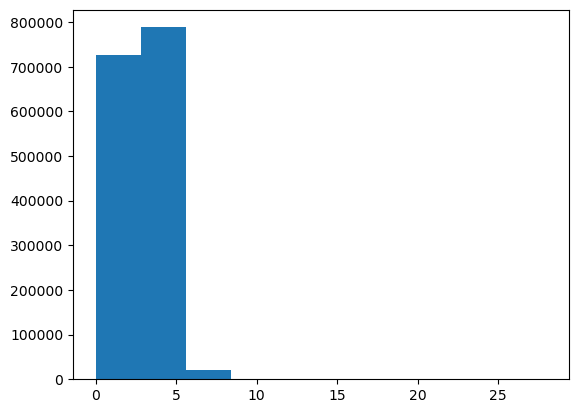

In [14]:
plt.figure()
plt.hist(np.log10(targ2.assay_value + 1))
plt.show()

In [5]:
targ3 = targ2[['inchi_key', 'uniprot_id']].drop_duplicates() 

print('# of unique targets:', targ3.shape[0])
print('# of unique drugs:', targ3.inchi_key.nunique())
print('# of unique proteins:', targ3.uniprot_id.nunique())

# of unique targets: 1242670
# of unique drugs: 545880
# of unique proteins: 3473


In [39]:
targ2[lambda x: (x.inchi_key == 'JWNPDZNEKVCWMY-VQHVLOKHSA-N') & (x.assay_value < 1 * 1e3)].shape

(97, 8)

In [24]:
targ2[lambda x: (x.inchi_key == 'JWNPDZNEKVCWMY-VQHVLOKHSA-N') & (x.assay_type == 'Kd')][['inchi_key', 'uniprot_id']].drop_duplicates().shape

(460, 2)

(array([436.,   2., 257.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.30000000e-01, 1.33001170e+04, 2.66001040e+04, 3.99000910e+04,
        5.32000780e+04, 6.65000650e+04, 7.98000520e+04, 9.31000390e+04,
        1.06400026e+05, 1.19700013e+05, 1.33000000e+05]),
 <BarContainer object of 10 artists>)

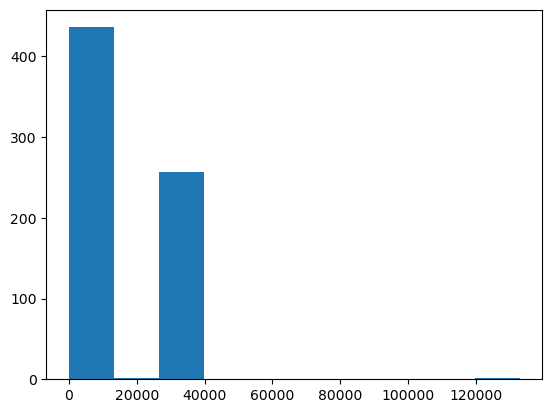

In [8]:
plt.figure()
plt.hist(targ2[lambda x: x.inchi_key == 'JWNPDZNEKVCWMY-VQHVLOKHSA-N'].assay_value)

In [70]:
druginfo = pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t')
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A08715367,L-theanine,NaN,NaN,CCNC(=O)CCC(N)C(O)=O,DATAGRPVKZEWHA-UHFFFAOYSA-N,l-theanine
1,BRD-A12237696,L-citrulline,NaN,NaN,NC(CCCNC(N)=O)C(O)=O,RHGKLRLOHDJJDR-UHFFFAOYSA-N,l-citrulline
2,BRD-A18795974,BRD-A18795974,NaN,NaN,CCCN(CCC)C1CCc2ccc(O)cc2C1,BLYMJBIZMIGWFK-UHFFFAOYSA-N,7-hydroxy-DPAT
3,BRD-A27924917,BRD-A27924917,NaN,NaN,NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1,WBSMZVIMANOCNX-UHFFFAOYSA-N,2-hydroxysaclofen
4,BRD-A35931254,BRD-A35931254,NaN,NaN,CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-UHFFFAOYSA-N,r(-)-apomorphine


In [71]:
targ2.head()

,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,P78417,29652143.0,pubchem_bioassay,IC50,=,900000.0
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P0DMS8,19282184.0,pubchem_bioassay,Ki,>,100000.0
2,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29274,19282184.0,pubchem_bioassay,Ki,=,2200.0
3,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29275,19282184.0,pubchem_bioassay,Ki,>,30000.0
4,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P30542,19282184.0,pubchem_bioassay,Ki,=,7400.0


In [81]:
targ2dep = targ2.merge(druginfo[['pert_id', 'inchi_key']].drop_duplicates(), on='inchi_key', how='inner')
targ2dep = targ2dep[lambda x: x.assay_relation == '=']
targ2dep = targ2dep.groupby(['pert_id', 'uniprot_id', 'inchi_key'])[['assay_value']].mean().reset_index()
targ2dep.head()

,pert_id,uniprot_id,inchi_key,assay_value
0,BRD-A00218260,O75469,QHMWCHQXCUNUAK-UHFFFAOYSA-N,6100.0
1,BRD-A00218260,Q96RI1,QHMWCHQXCUNUAK-UHFFFAOYSA-N,13800.0
2,BRD-A00520476,P08172,UBRKDAVQCKZSPO-UHFFFAOYSA-N,81.0
3,BRD-A00520476,P08173,UBRKDAVQCKZSPO-UHFFFAOYSA-N,407.0
4,BRD-A00520476,P08912,UBRKDAVQCKZSPO-UHFFFAOYSA-N,2800.0


In [82]:
print('# of unique drugs:', targ2dep.inchi_key.nunique())
print('# of unique targets:', targ2dep.uniprot_id.nunique())
print('# of unique DTIs :', targ2dep[['inchi_key', 'uniprot_id']].drop_duplicates().shape[0])

# of unique drugs: 3312
# of unique targets: 2124
# of unique DTIs : 26276


In [84]:
targ2dep[lambda x: (x.inchi_key == 'JWNPDZNEKVCWMY-VQHVLOKHSA-N') & (x.assay_value < 1 * 1e3)].shape

(52, 4)

In [85]:
tinfo = pd.read_csv('../../../data/targetome_extended_drugs-01-23-25.csv')
tinfo.head()

/tmp/ipykernel_23019/932503711.py:1: DtypeWarning: Columns (10,11,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  tinfo = pd.read_csv('../../../data/targetome_extended_drugs-01-23-25.csv')


,pubchem_cid,inchi_key,clinical_phase,drug_name,chembl_id,therapeutic_flag,molecule_type,withdrawn_flag,chemical_probe,natural_product,drugbank_status,drugbank_type,iuphar_type,iuphar_status,atc,mesh,pharm_mesh,nci,inchi
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,Phase 1 Clinical Trials,Dinitrochlorobenzene,CHEMBL292687,0.0,Small molecule,0.0,0.0,0.0,investigational,small molecule,NaN,NaN,NaN,Dinitrochlorobenzene,Indicators and Reagents|Irritants,"C1908 - Drug, Food, Chemical or Biomedical Mat...",InChI=1S/C6H3ClN2O4/c7-5-2-1-4(8(10)11)3-6(5)9...
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,preclinical compounds with bioactivity data,9-ethyladenine,CHEMBL304009,0.0,Small molecule,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,9-ethyladenine,NaN,NaN,InChI=1S/C7H9N5/c1-2-12-4-11-5-6(8)9-3-10-7(5)...
2,19,GLDQAMYCGOIJDV-UHFFFAOYSA-N,preclinical compounds with bioactivity data,"2,3-dihydroxybenzoic Acid",CHEMBL1432,0.0,Small molecule,0.0,0.0,1.0,experimental,small molecule,NaN,NaN,NaN,"2,3-dihydroxybenzoic acid",Iron Chelating Agents,NaN,InChI=1S/C7H6O4/c8-5-3-1-2-4(6(5)9)7(10)11/h1-...
3,43,HWXBTNAVRSUOJR-UHFFFAOYSA-N,preclinical compounds with bioactivity data,Alpha-hydroxyglutarate,CHEMBL4870693,0.0,Unknown,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,alpha-hydroxyglutarate,NaN,"C1908 - Drug, Food, Chemical or Biomedical Mat...","InChI=1S/C5H8O5/c6-3(5(9)10)1-2-4(7)8/h3,6H,1-..."
4,51,KPGXRSRHYNQIFN-UHFFFAOYSA-N,preclinical compounds with bioactivity data,Alpha-ketoglutaric Acid,CHEMBL1686,0.0,Small molecule,0.0,0.0,1.0,NaN,NaN,metabolite,NaN,NaN,Ketoglutaric Acids,NaN,"C1908 - Drug, Food, Chemical or Biomedical Mat...","InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(..."


In [94]:
inhibitors = ['inhibitor' in str(x) for x in tinfo.atc.unique()]
agonists = ['agonist' in str(x) for x in tinfo.atc.unique()]
targeted_therapy = ['Targeted Therapy Agent' in str(x) for x in tinfo.atc.unique()]
print(f'# of inhibitors: {sum(inhibitors)}/{len(inhibitors)} [{sum(inhibitors)/len(inhibitors)*100:.2f}%]')
print(f'# of agonists: {sum(agonists)}/{len(agonists)} [{sum(agonists)/len(agonists)*100:.2f}%]')
print(f'# of targeted therapy: {sum(targeted_therapy)}/{len(targeted_therapy)} [{sum(targeted_therapy)/len(targeted_therapy)*100:.2f}%]')

# of inhibitors: 208/1435 [14.49%]
# of agonists: 391/1435 [27.25%]
# of targeted therapy: 93/1435 [6.48%]


In [98]:
tinfo.groupby('atc').count()[['pubchem_cid']].sort_values('pubchem_cid', ascending=False).head(10)

,pubchem_cid
atc,
"C - Cardiovascular system > C09 - Agents acting on the renin-angiotensin system > C09A - Ace inhibitors, plain > C09AA - Ace inhibitors, plain|C471 - Enzyme Inhibitor > C783 - Protease Inhibitor > C247 - ACE Inhibitor|C78274 - Agent Affecting Cardiovascular System > C270 - Antihypertensive Agent|D002317 - Cardiovascular Agents > D000959 - Antihypertensive Agents|D004791 - Enzyme Inhibitors > D011480 - Protease Inhibitors > D000806 - Angiotensin-Converting Enzyme Inhibitors",9
C254 - Anti-Infective Agent > C258 - Antibiotic > C260 - Beta-Lactam Antibiotic|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D002511 - Cephalosporins|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D007769 - Lactams|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D047090 - beta-Lactams|J - Antiinfectives for systemic use > J01 - Antibacterials for systemic use > J01D - Other beta-lactam antibacterials > J01DD - Third-generation cephalosporins,7
"C78272 - Agent Affecting Nervous System > C245 - Anesthetic Agent|D002491 - Central Nervous System Agents > D002492 - Central Nervous System Depressants > D000777 - Anesthetics|D018373 - Peripheral Nervous System Agents > D018689 - Sensory System Agents|N - Nervous system > N01 - Anesthetics > N01B - Anesthetics, local > N01BB - Amides",7
C78281 - Agent Affecting Musculoskeletal System > C67439 - Bone Resorption Inhibitor|D050071 - Bone Density Conservation Agents > D004164 - Diphosphonates|M - Musculo-skeletal system > M05 - Drugs for treatment of bone diseases > M05B - Drugs affecting bone structure and mineralization > M05BA - Bisphosphonates,6
C274 - Antineoplastic Agent > C163758 - Targeted Therapy Agent > C62554 - Poly (ADP-Ribose) Polymerase Inhibitor|C471 - Enzyme Inhibitor|D000970 - Antineoplastic Agents > D000067856 - Poly(ADP-ribose) Polymerase Inhibitors|D004791 - Enzyme Inhibitors|L - Antineoplastic and immunomodulating agents > L01 - Antineoplastic agents > L01X - Other antineoplastic agents > L01XK - Poly (adp-ribose) polymerase (parp) inhibitors,6
C254 - Anti-Infective Agent > C258 - Antibiotic > C260 - Beta-Lactam Antibiotic|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D002511 - Cephalosporins|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D007769 - Lactams|D000890 - Anti-Infective Agents > D000900 - Anti-Bacterial Agents > D047090 - beta-Lactams|J - Antiinfectives for systemic use > J01 - Antibacterials for systemic use > J01D - Other beta-lactam antibacterials > J01DB - First-generation cephalosporins,6
C - Cardiovascular system > C08 - Calcium channel blockers > C08C - Selective calcium channel blockers with mainly vascular effects > C08CA - Dihydropyridine derivatives|C78274 - Agent Affecting Cardiovascular System > C270 - Antihypertensive Agent > C333 - Calcium Channel Blocker|C93038 - Cation Channel Blocker|D000077264 - Calcium-Regulating Hormones and Agents|D002317 - Cardiovascular Agents > D000959 - Antihypertensive Agents|D002317 - Cardiovascular Agents > D002121 - Calcium Channel Blockers|D002317 - Cardiovascular Agents > D014665 - Vasodilator Agents|D049990 - Membrane Transport Modulators,5
"A - Alimentary tract and metabolism > A10 - Drugs used in diabetes > A10B - Blood glucose lowering drugs, excl. insulins > A10BB - Sulfonylureas|C78276 - Agent Affecting Digestive System or Metabolism > C29711 - Anti-diabetic Agent > C97936 - Sulfonylurea Antidiabetic Agent|D007004 - Hypoglycemic Agents",5
C78272 - Agent Affecting Nervous System > C47794 - Serotonin Agonist|D018377 - Neurotransmitter Agents > D018490 - Serotonin Agents > D017366 - Serotonin Receptor Agonists|N - Nervous system > N02 - Analgesics > N02C - Antimigraine preparations > N02CC - Selective serotonin (5ht1) agonists,5


In [ ]:
# look at ATC codes... can we select kinase inhibitors only? 

In [69]:
test_ixs = torch.load('../../output/sciplex3/test_idxs.pt', weights_only=False)
test_ixs[:10]

tensor([141974, 162996, 119264, 333856, 261918, 320199, 198319, 133951, 316404,
        234682])

In [77]:
y_fnames = [x for x in os.listdir('../../output/sciplex3/PROC/') if x[:4] == 'pert']

y = [] 
for i,fname in enumerate(y_fnames[0:10000]):
    print(f'loading data...{i}/{len(y_fnames)}', end='\r')
    y.append(torch.load(f'../../output/sciplex3/PROC/{fname}', weights_only=True).view(1,-1))
y = torch.cat(y, dim=0)
y.size()

torch.Size([10000, 748])

In [78]:
reducer = PCA(n_components=2)
y_reduced = reducer.fit_transform(y.cpu().numpy())

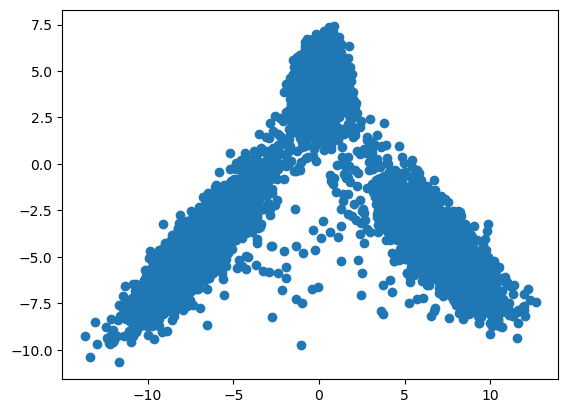

In [79]:
plt.figure() 
plt.scatter(y_reduced[:,0], y_reduced[:,1])
plt.show()

In [51]:
test_cell_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_cell_metrics.csv')
test_drug_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_drug_metrics.csv')
test_gene_gsnn = pd.read_csv('/home/teddy/local/gsnn-lib/output/GSNN/9d01f9ff-f298-4efa-8361-6c39bd017764/test_gene_metrics.csv')

test_cell_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_cell_metrics.csv')
test_drug_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_drug_metrics.csv')
test_gene_nn = pd.read_csv('/home/teddy/local/gsnn-lib/output/NN/1ecf582d-a6de-41d1-a4ea-c7cb0f87653e/test_gene_metrics.csv')

In [55]:
drug_df = test_drug_gsnn.merge(test_drug_nn, on='pert_id', suffixes=('_gsnn', '_nn'))
cell_df = test_cell_gsnn.merge(test_cell_nn, on='cell_iname', suffixes=('_gsnn', '_nn'))
gene_df = test_gene_gsnn.merge(test_gene_nn, on='gene', suffixes=('_gsnn', '_nn'))

In [65]:
gene_df.set_index('gene').loc['P04637']

r2_gsnn           0.079641
mse_gsnn          2.096609
pearsonr_gsnn     0.287494
spearmanr_gsnn    0.181472
r2_nn             0.054432
mse_nn            2.154035
pearsonr_nn       0.237790
spearmanr_nn      0.186867
Name: P04637, dtype: float64

In [57]:
print('nn spearman', test_gene_nn.spearmanr.mean())
print('gsnn spearman', test_gene_gsnn.spearmanr.mean())

nn 0.21994850155285434
gsnn 0.1765563545241229


In [58]:
print('nn pearson', test_gene_nn.pearsonr.mean())
print('gsnn pearson', test_gene_gsnn.pearsonr.mean())

nn pearson 0.3495320968951823
gsnn pearson 0.35065872652846847


In [59]:
print('nn r2', test_gene_nn.r2.mean())
print('gsnn r2', test_gene_gsnn.r2.mean())

nn r2 0.13295216438097826
gsnn r2 0.13133975318354416


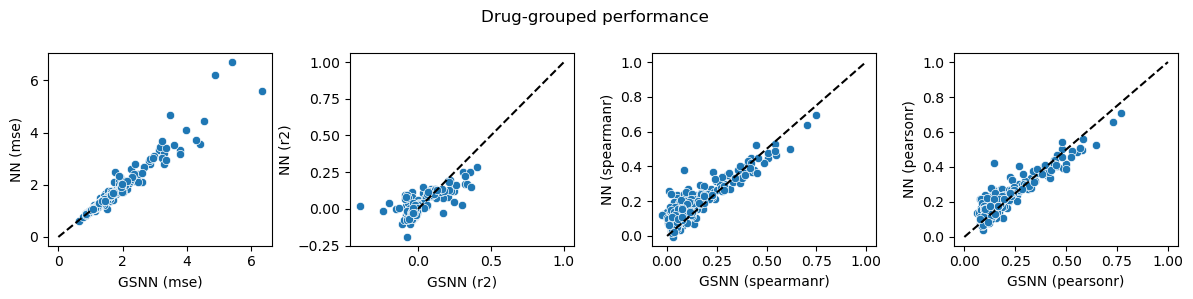

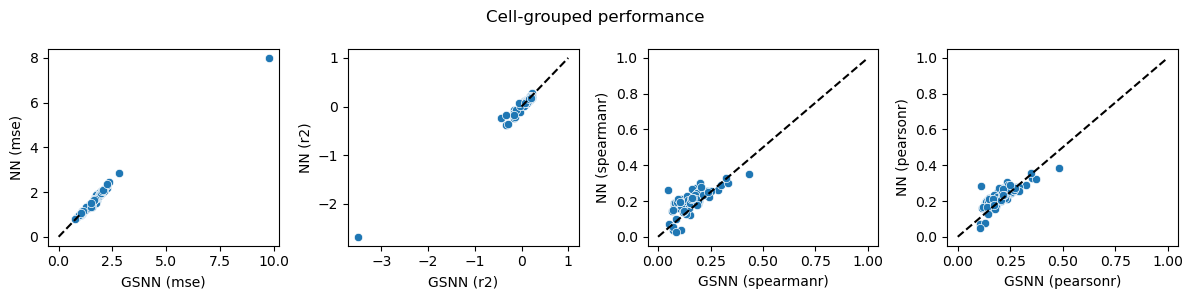

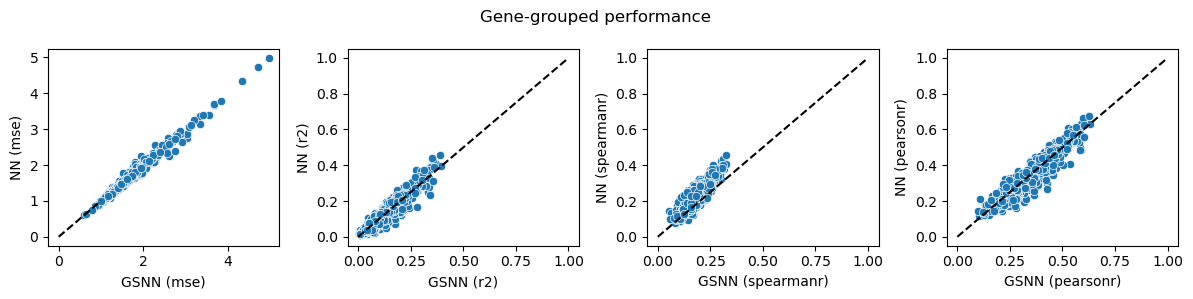

In [56]:
f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=drug_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Drug-grouped performance')
plt.tight_layout()
plt.show()

f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=cell_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Cell-grouped performance')
plt.tight_layout()
plt.show()


f, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, metric in zip(axes, ['mse', 'r2', 'spearmanr', 'pearsonr']):
    sbn.scatterplot(data=gene_df, x=f'{metric}_gsnn', y=f'{metric}_nn', ax=ax)
    ax.plot((0,1), (0,1), 'k--')
    ax.set_xlabel(f'GSNN ({metric})')
    ax.set_ylabel(f'NN ({metric})')

plt.suptitle('Gene-grouped performance')
plt.tight_layout()
plt.show()

NameError: name 'test_gsnn_drug' is not defined

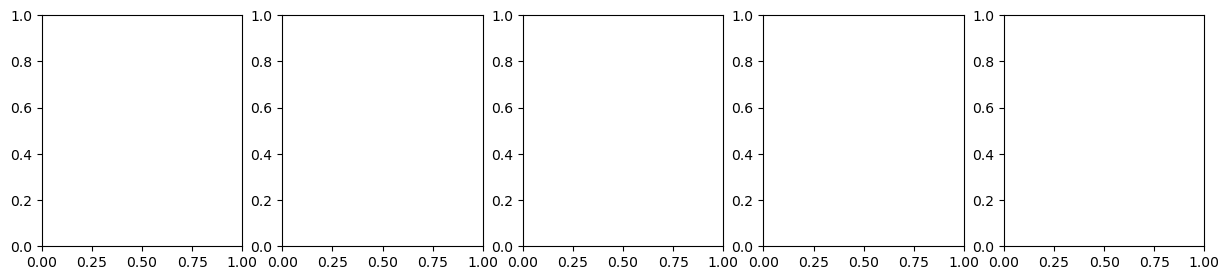

In [60]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(test_gsnn_drug.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_gsnn_drug.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_gsnn_drug.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_gsnn_drug.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(test_gsnn_drug.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Drug-grouped metrics')
plt.tight_layout()
plt.show()

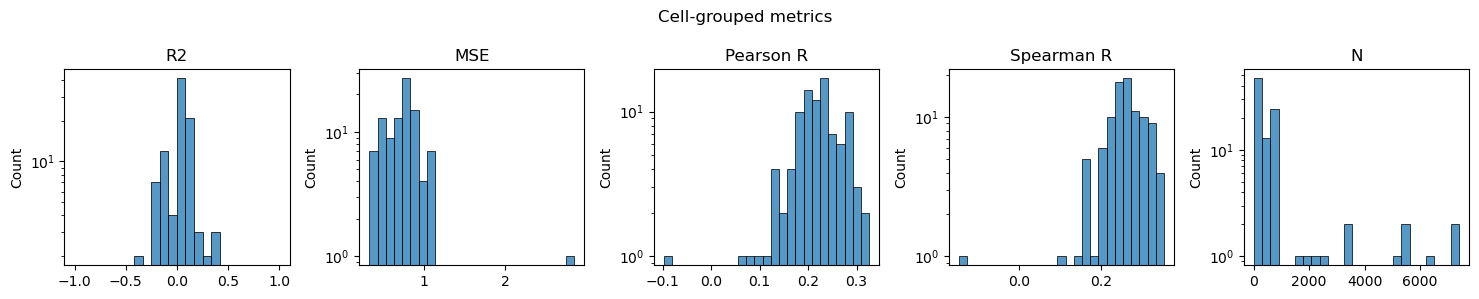

In [30]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(test_cell.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_cell.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_cell.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_cell.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(test_cell.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Cell-grouped metrics')
plt.tight_layout()
plt.show()

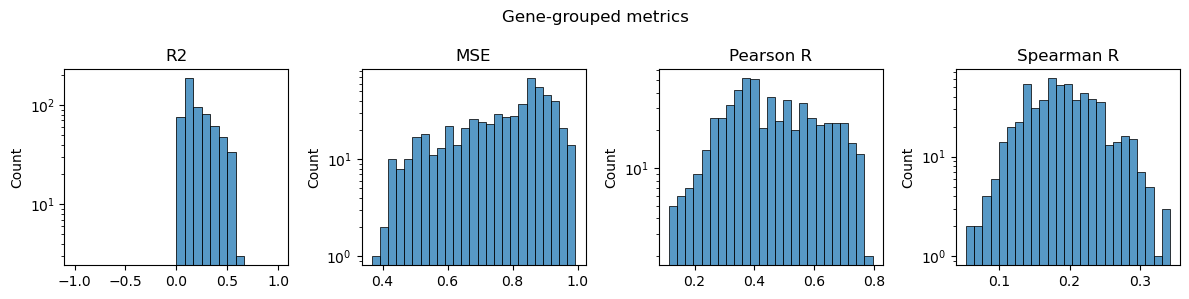

In [31]:
f, axes = plt.subplots(1, 4, figsize=(12,3))
sbn.histplot(test_gene.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(test_gene.mse.values, ax=axes[1], bins=25)
sbn.histplot(test_gene.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(test_gene.spearmanr.values, ax=axes[3], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')

for ax in axes:
    ax.set_yscale('log')
    
plt.suptitle('Gene-grouped metrics')
plt.tight_layout()
plt.show()

In [6]:
def agg_fold_metrics(path):

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    metrics = []
    for fold in folds:
        fold_path = os.path.join(path, fold)
        metrics.append(torch.load(os.path.join(fold_path, 'result_metric_dict.pt'), weights_only=False))

    avg_metrics = {} 
    for key in metrics[0].keys():
        avg_metrics[key] = np.mean([x[key] for x in metrics])

    return avg_metrics

In [2]:
def agg_fold_val_metrics(path):

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    

def agg_fold_predictions(path): 
    '''
    Aggregate test predictions from all folds in a given path (uid)
    '''

    folds = np.sort([x for x in os.listdir(path) if os.path.isdir(os.path.join(path, x))])
    
    preds = [] 
    sig_ids = []
    for fold in folds:
        preds.append( torch.load(path + '/' + fold + '/test_predictions.pt', weights_only=False))
        sig_ids.append( np.concatenate(torch.load(path + '/' + fold + '/test_sig_ids.pt', weights_only=False)) ) 

    sig_ids = np.concatenate(sig_ids, 0)
    preds = np.concatenate(preds, 0)

    return preds, sig_ids

def load_y(proc, sig_ids): 
    ''' 
    Load y from processed data
    '''

    y = [] 
    for i,sig_id in enumerate(sig_ids): 
        print('progress: ', i, ' / ', len(sig_ids), end='\r')
        y.append( torch.load(proc + '/obs/' + sig_id + '.pt', weights_only=True) ) 

    y = torch.stack(y, 0)
    y = y.detach().cpu().numpy()
    return y 

def grouped_eval(y, preds, sig_ids, data, siginfo):

    siginfo = siginfo[lambda x: x.sig_id.isin(sig_ids)]  
    sig2idx = {x:i for i,x in enumerate(sig_ids)}

    drug_metrics = {'pert_id': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr':[], 'N':[]}
    for i,row in siginfo[['pert_id', 'sig_id']].groupby('pert_id').agg(lambda x: list(x)).reset_index().iterrows(): 
        print('calculating drug-grouped metrics... ', i, ' / ', len(siginfo.pert_id.unique()), end='\r')
        didxs = [sig2idx[x] for x in row.sig_id]
        yy = y[didxs]
        yyhat = preds[didxs] 

        drug_metrics['pert_id'].append(row.pert_id)
        drug_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat, multioutput='variance_weighted'))
        drug_metrics['mse'].append( np.mean((yy - yyhat)**2) )  
        drug_metrics['pearsonr'].append( np.mean([np.corrcoef(yy[i], yyhat[i])[0,1] for i in range(yy.shape[0])]) )
        drug_metrics['spearmanr'].append( np.mean([scipy.stats.spearmanr(yy[i], yyhat[i]).statistic for i in range(yy.shape[0])]) )
        drug_metrics['N'].append(yy.shape[0])

    drug_metrics = pd.DataFrame(drug_metrics)
    print()

    ### performance by cell line 
    cell_metrics = {'cell_iname': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr':[], 'N':[]}
    for i,row in siginfo[['cell_iname', 'sig_id']].groupby('cell_iname').agg(lambda x: list(x)).reset_index().iterrows(): 
        print('calculating cell-grouped metrics... ', i, ' / ', len(siginfo.cell_iname.unique()), end='\r')
        didxs = [sig2idx[x] for x in row.sig_id]
        yy = y[didxs]
        yyhat = preds[didxs] 

        cell_metrics['cell_iname'].append(row.cell_iname)
        cell_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat, multioutput='variance_weighted'))
        cell_metrics['mse'].append( np.mean((yy - yyhat)**2) )  
        cell_metrics['pearsonr'].append( np.mean([np.corrcoef(yy[i], yyhat[i])[0,1] for i in range(yy.shape[0])]) )
        cell_metrics['spearmanr'].append( np.mean([scipy.stats.spearmanr(yy[i], yyhat[i]).statistic for i in range(yy.shape[0])]) )
        cell_metrics['N'].append(yy.shape[0])

    cell_metrics = pd.DataFrame(cell_metrics)
    print()

    ### performance by genes
    lincspace = data['node_names_dict']['output']
    gene_metrics = {'gene': [], 'r2': [], 'mse': [], 'pearsonr': [], 'spearmanr': []}
    for i in range(y.shape[1]): 
        print('calculating gene-grouped metrics... ', i, ' / ', y.shape[1], end='\r')

        yy = y[:,i]
        yyhat = preds[:,i]
        gene = lincspace[i].split('_')[1]

        gene_metrics['gene'].append(gene)
        gene_metrics['r2'].append(sklearn.metrics.r2_score(yy, yyhat))
        gene_metrics['mse'].append(np.mean((yy - yyhat)**2))
        gene_metrics['pearsonr'].append(np.corrcoef(yy, yyhat)[0,1])
        gene_metrics['spearmanr'].append(scipy.stats.spearmanr(yy, yyhat).statistic)
            
    gene_metrics = pd.DataFrame(gene_metrics)
    print() 

    return drug_metrics, cell_metrics, gene_metrics


In [3]:
path = '/home/teddy/local/gsnn-lib/output/5dfaa74e-6691-435a-992d-2a87ca2756d0'
proc = '../../proc/lincs/'

siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)
data = torch.load(proc + '/data.pt', weights_only=False)

avg_metrics = agg_fold_metrics(path)
preds, sig_ids = agg_fold_predictions(path)
y = load_y(proc, sig_ids)
drug_metrics, cell_metrics, gene_metrics = grouped_eval(y, preds, sig_ids, data, siginfo)

/tmp/ipykernel_13247/488584742.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sig_ids.append( np.concatenate(torch.load(path + '/' + fold + '/test_sig_ids.pt' )) )


In [15]:
drug_metrics.r2.max()

0.037919122725725174

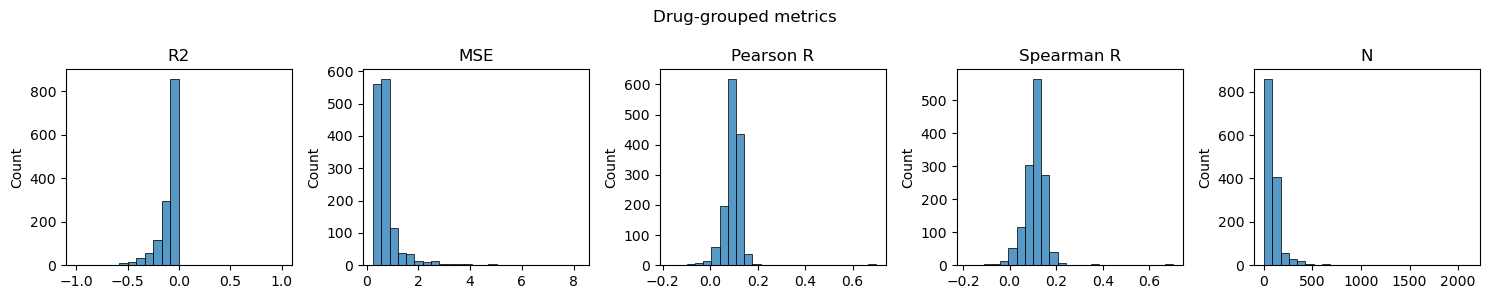

In [5]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(drug_metrics.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(drug_metrics.mse.values, ax=axes[1], bins=25)
sbn.histplot(drug_metrics.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(drug_metrics.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(drug_metrics.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')
plt.suptitle('Drug-grouped metrics')
plt.tight_layout()
plt.show()

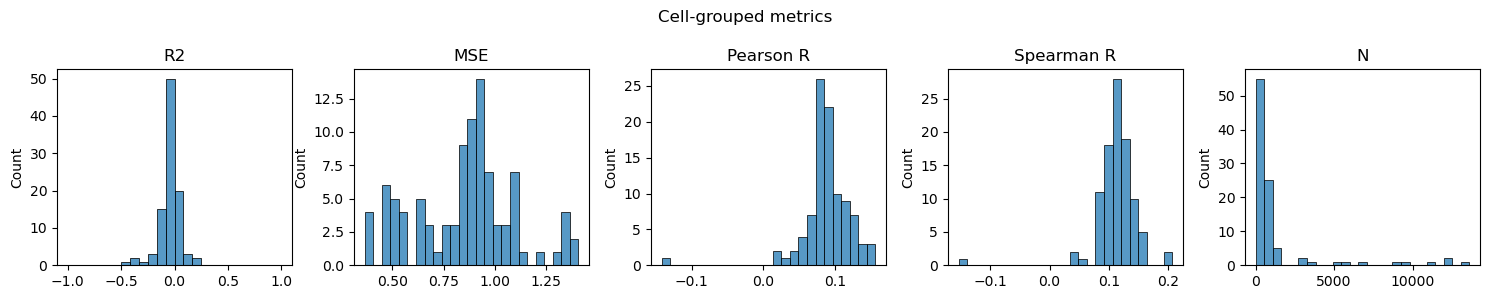

In [4]:
f, axes = plt.subplots(1, 5, figsize=(15,3))
sbn.histplot(cell_metrics.r2.values, ax=axes[0], bins=np.linspace(-1,1,25))
sbn.histplot(cell_metrics.mse.values, ax=axes[1], bins=25)
sbn.histplot(cell_metrics.pearsonr.values, ax=axes[2], bins=25)
sbn.histplot(cell_metrics.spearmanr.values, ax=axes[3], bins=25)
sbn.histplot(cell_metrics.N.values, ax=axes[4], bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearson R')
axes[3].set_title('Spearman R')
axes[4].set_title('N')
plt.suptitle('Cell-grouped metrics')
plt.tight_layout()
plt.show()

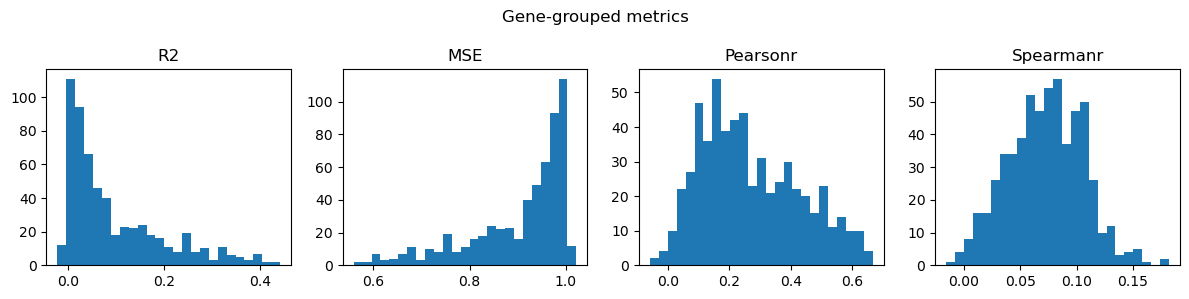

In [17]:
f, axes = plt.subplots(1, 4, figsize=(12,3))
axes[0].hist(gene_metrics.r2.values, bins=25)
axes[1].hist(gene_metrics.mse.values, bins=25)
axes[2].hist(gene_metrics.pearsonr.values, bins=25)
axes[3].hist(gene_metrics.spearmanr.values, bins=25)

axes[0].set_title('R2')
axes[1].set_title('MSE')
axes[2].set_title('Pearsonr')
axes[3].set_title('Spearmanr')

plt.suptitle('Gene-grouped metrics')
plt.tight_layout()
plt.show()

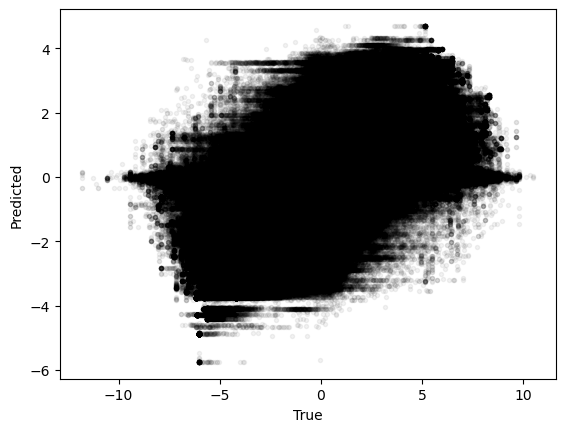

In [18]:
plt.figure() 
plt.plot(y.ravel(), preds.ravel(), 'k.' ,alpha=0.01)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show() 

In [13]:
siginfo = pd.read_csv(f'../../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [15]:
siginfo.pert_type.unique()

array(['trt_cp', 'trt_oe', 'trt_sh', 'trt_si', 'trt_aby', 'trt_lig',
       'trt_xpr', 'ctl_vector', 'ctl_vehicle', 'ctl_untrt',
       'ctl_vector.cns', 'ctl_vehicle.cns', 'ctl_untrt.cns', 'ctl_x',
       'trt_sh.cgs', 'trt_sh.css'], dtype=object)

In [18]:
' '.join(siginfo[lambda x: x.pert_type == 'trt_cp'].groupby('pert_id').count()[['bead_batch']].sort_values('bead_batch', ascending=False).reset_index().head(10).pert_id.values)

'BRD-K60230970 BRD-K50691590 BRD-K81418486 BRD-K49865102 BRD-K21680192 BRD-K88510285 BRD-A79768653 BRD-A75409952 BRD-K49328571 BRD-A19037878'

In [12]:
train_ids = np.load(f'../../data/all/lincs_train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root=f'../../data/all', sig_ids=train_ids, data=data, siginfo=siginfo)

In [14]:
x, y, sig_id = train_dataset.__getitem__(0)

In [17]:
with torch.no_grad(): 
    yhat = model(x.cuda())

RuntimeError: The size of tensor a (5515715790) must match the size of tensor b (21702600) at non-singleton dimension 0

In [2]:

data = torch.load('../../data/all/data.pt')
model = GSNN(data.edge_index_dict, 
             data.node_names_dict, 
             channels=5, 
             layers=5)

x = torch.randn((10, len(data.node_names_dict['input'])))


with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(x)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

INFO:2024-09-13 21:05:33 17909:17909 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
STAGE:2024-09-13 21:05:33 17909:17909 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::scatter_add_        42.22%     224.121ms        42.22%     224.121ms       8.965ms           0 b           0 b            25  
                    aten::mul        14.09%      74.804ms        14.09%      74.804ms       3.937ms     327.32 Mb     327.32 Mb            19  
           aten::index_select        14.03%      74.470ms        14.06%      74.623ms       3.731ms     194.68 Mb     194.68 Mb            20  
                  aten::copy_        11.52%      61.136ms        11.52%      61.136ms       1.747ms           0 b           0 b         

STAGE:2024-09-13 21:05:34 17909:17909 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-13 21:05:34 17909:17909 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [8]:
data = torch.load('../../data/all/data.pt')
model = GSNN(data.edge_index_dict, 
             data.node_names_dict, 
             channels=5, 
             layers=5).cuda()

x = torch.randn((10, len(data.node_names_dict['input']))).cuda()

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference        17.02%       5.138ms       100.00%      30.184ms      30.184ms             1  
                  aten::zeros         0.07%      20.000us         0.36%     108.000us      54.000us             2  
                  aten::empty         1.15%     346.000us         1.15%     346.000us       3.531us            98  
                  aten::zero_         0.38%     114.000us         2.20%     663.000us      24.556us            27  
                  aten::fill_         2.29%     691.000us         2.29%     691.000us      20.939us            33  
                  aten::slice         0.27%      82.000us         0.29% 

STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-13 21:07:50 17909:17909 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [7]:
print(prof.key_averages().table())

In [16]:
args = argparse.Namespace()
args.data ='../../../data/'
data = torch.load('../../data/all/data.pt')
drugspace = [x.split('__')[1] for x in data.node_names_dict['input'] if 'DRUG__' in x]
prism = load_prism(args.data, cellspace=data.cellspace, drugspace=drugspace)

/home/teddy/local/GSNN/gsnn/proc/utils.py:163: FutureWarning: The provided callable <function mean at 0x7f100ad080e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  prism = prism.groupby(['pert_id', 'depmap_id', 'cell_iname', 'pert_dose']).agg({'log_fold_change':np.mean, 'screen_id':list}).reset_index()


In [17]:
prism.head()

,pert_id,depmap_id,cell_iname,pert_dose,log_fold_change,screen_id,num_repl,sig_id,cell_viab
0,BRD-A00147595,ACH-000012,HCC827,2.5,0.088670,[primary],1,HCC827::BRD-A00147595::2.5,1.063389
1,BRD-A00147595,ACH-000019,MCF7,2.5,0.018010,[primary],1,MCF7::BRD-A00147595::2.5,1.012562
2,BRD-A00147595,ACH-000048,TOV112D,2.5,0.461293,[primary],1,TOV112D::BRD-A00147595::2.5,1.376775
3,BRD-A00147595,ACH-000052,A673,2.5,0.518615,[primary],1,A673::BRD-A00147595::2.5,1.432579
4,BRD-A00147595,ACH-000087,SKES1,2.5,0.781814,[primary],1,SKES1::BRD-A00147595::2.5,1.719291


In [ ]:
prism.assign()

In [4]:
siginfo = pd.read_csv('../../../data/siginfo_beta.txt', sep='\t', low_memory=False)
siginfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


In [8]:
siginfo[lambda x: x.pert_type == 'trt_cp'].groupby('pert_time').count().sort_values('sig_id', ascending=False)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time_unit,cell_mfc_name,pert_mfc_id,nsample,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
pert_time,,,,,,,,,,,,,,,,,,,,,
24.0,559163,558320,559107,559163,559107,559163,559163,559163,559163,559163,...,559163,559163,559163,559163,0,559163,559163,559163,559163,559163
6.0,138006,137994,137961,137997,137961,138006,138006,138006,138006,138006,...,138006,138006,138006,138006,0,138006,138006,138006,138006,138006
3.0,11998,11974,11998,11998,11998,11998,11998,11998,11998,11998,...,11998,11998,11998,11998,0,11998,11998,11998,11998,11998
4.0,4704,3492,4704,4704,4704,4704,4704,4704,4704,4704,...,4704,4704,4704,4704,0,4704,4704,4704,4704,4704
48.0,4372,4369,4372,4372,4372,4372,4372,4372,4372,4372,...,4372,4372,4372,4372,0,4372,4372,4372,4372,4372
72.0,796,793,796,796,796,796,796,796,796,796,...,796,796,796,796,0,796,796,796,796,796
12.0,360,357,360,360,360,360,360,360,360,360,...,360,360,360,360,0,360,360,360,360,360
-666.0,230,230,230,230,230,0,230,230,230,230,...,230,230,230,230,0,230,230,230,230,230
2.0,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,0,188,188,188,188,188


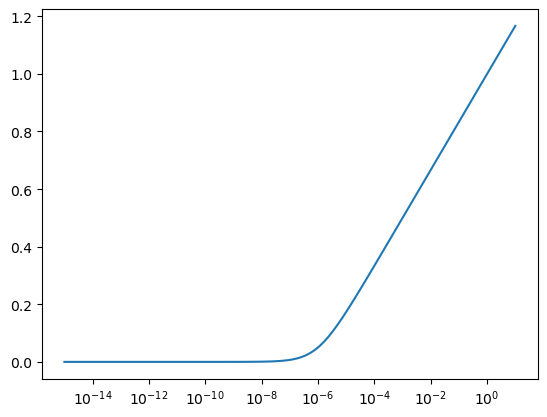

In [10]:
plt.figure() 
x = np.logspace(-15,1, 100)
y = -(np.log10(x + 1e-6) - np.log10(1e-6))/np.log10(1e-6)
plt.plot(x,y)
plt.xscale('log')
plt.show()

In [2]:
mut = load_mut(path='../../../data/', extpath='../../extdata/', include_variants=['damaging'])

In [4]:
mut[['P04637']].head() # TP53 

uniprot,P04637
cell_iname,
22RV1,1.0
5637,0.0
A204,0.0
A375,0.0
A549,0.0


In [5]:
mut[['P04637']].sum()

uniprot
P04637    31.0
dtype: float64

In [9]:
mut[['P01116']].sum()

uniprot
P01116    2.0
dtype: float64